# Section 1: Perimeter Visualization 

Link to repo: https://github.com/leirubinstein/eds220-hwk4 (more content available here!)

## About

**Purpose:**

Here we use historical fire perimeter data from CalFire to obtain the perimeter of the [2017 Thomas Fire](https://www.fire.ca.gov/incidents/2017/12/4/thomas-fire/). The, using provided Landsat imagery and the fire perimeter, we create a map showing the perimeter of the [2017 Thomas Fire](https://www.fire.ca.gov/incidents/2017/12/4/thomas-fire/) in relation to Santa Barbara County.

**Highlights:**

- Cleaning data
- Label-based selection
- Geospatial file creation
- `rioxarray` raster file manipulation 
- True color imagery plotting
- False color imagery plotting

**Dataset Descriptions**: 

The `landsat` data is a simplified collection of bands from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. This data was retrieved from the [Microsoft Planetary Computer data catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and pre-processed to remove data outside land and coarsen the spatial resolution.

California's Fire and Resource Assessment Program (FRAP) maintains a comprehensive database of historical fire perimeters throughout the state, covering both public and private lands. This GIS dataset is updated annually through a collaborative effort between FRAP and several federal agencies - the U.S. Forest Service Region 5, Bureau of Land Management, National Park Service, and Fish and Wildlife Service.

**References:**

- Fire Resource and Assessment Program. (2024). *Historical Fire Perimeters* CalFire. https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters

- NASA Landsat 8 (2024). *Landsat Collection 2 Level-2 Science Products* Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from shapely import box
from IPython.display import Image 

In [2]:
# Load fire perimeter data
fire_perimeter = gpd.read_file(os.path.join('data',
                                            'fire23_1.gdb'))
fire_perimeter.head()
fire_perimeter.columns = fire_perimeter.columns.str.lower()

In [3]:
print(f"Fire Perimeter CRS: {fire_perimeter.crs} \nIs this projected?: {fire_perimeter.crs.is_projected}")

Fire Perimeter CRS: EPSG:3310 
Is this projected?: True


Here we obtain the coordinate reference system (EPSG:3310) of the fire perimeter data. This CRS is projected.

Let's create a mask of the Thomas Fire perimeter. First, filter the historical fire perimeters dataset to the 2017 Thomas Fire and then save as a geospatial file in the `data/` directory.

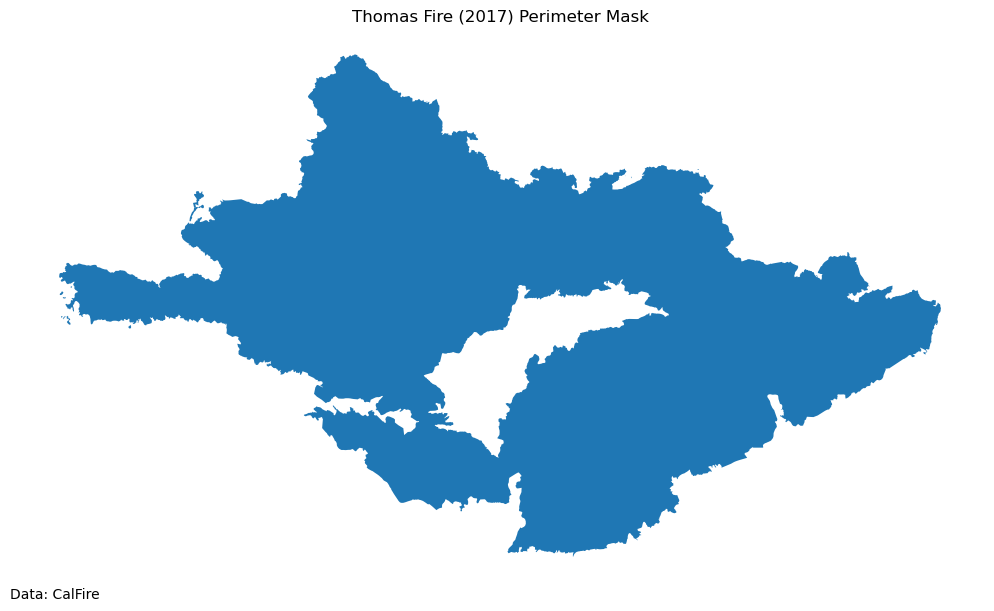

In [4]:
# Filter to the 2017 Thomas Fire
thomasfire = fire_perimeter.loc[(fire_perimeter['fire_name'] == 'THOMAS') & 
                                (fire_perimeter['year_'] == 2017)]

# Plot the perimeter
fig, ax = plt.subplots(figsize = (10,8))
ax.axis('off')
thomasfire.plot(ax=ax)
plt.tight_layout()
plt.subplots_adjust(bottom = 0.05)
ax.set_title('Thomas Fire (2017) Perimeter Mask')
plt.figtext(0.01, 0.15, "Data: CalFire", ha="left", fontsize=10)
plt.show()

In [5]:
# Save file to the data folder in `.geojson` format.
thomasfire.to_file('data/thomasfire.geojson', driver='GeoJSON')

GeoJSON is an open standard format that can represent a variety of geometries.

To plot true and false color images, we will use the Landsat data. The landsat data is accessed from workbench-1 at:

`/courses/EDS220/data/hwk4_landsat_data landsat8-2018-01-26-sb-simplified.nc`

In [6]:
# Import data
root = os.path.join('/',
                   'courses',
                   'EDS220',
                   'data',
                   'hwk4_landsat_data')

fp = os.path.join(root, 'landsat8-2018-01-26-sb-simplified.nc')

landsat = rioxr.open_rasterio(fp)

### Preliminary Data Exploration



In [7]:
# Check CRS of data and dimensions
print(
    f"{'Landsat 8 CRS:':<25} {landsat.rio.crs}\n"
    f"{'Is it projected?':<25} {landsat.rio.crs.is_projected}\n"
    f"{'Sizes of dimensions:':<25} {dict(landsat.sizes)}")

Landsat 8 CRS:            EPSG:32611
Is it projected?          True
Sizes of dimensions:      {'band': 1, 'x': 870, 'y': 731}


In [8]:
print(landsat)

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...


The landsat dataset has three dimensions: band, x, and y; it has variables for red, green, blue, near infrared 0.8, and short-wave infrared 2.2 bands. The coordinate reference system is EPSG: 32611 (projected).

The band dimension makes our raster three dimensional and is unnecessary. We can go ahead and “squeeze” the raster to simplify it:

In [9]:
# Drop the band dimension of the data
landsat = landsat.squeeze().drop_vars('band')

## True color image

Using the red, green, and blue bands from the landsat data, we can create a true-color visualization of Santa Barbara County. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


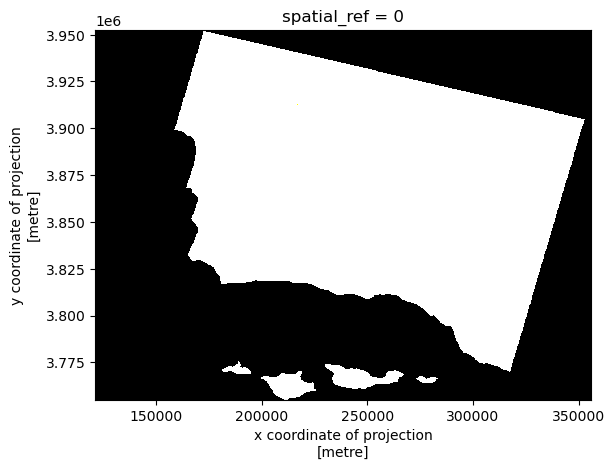

In [10]:
# Create true color visualization using red, green, blue bands
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

The plot is black and white; this is because there are a large number of high RBG values from clouds skewing the color scale for the plot.

Passing the `robust=True` parameter in `plt.imshow` prevents outliers from washing out the color scale of the plot. `robust=True` uses the  2nd and 98th percentiles of the data to compute the color limits. The adjusted output takes into account that the RGB values of the clouds are outliers.

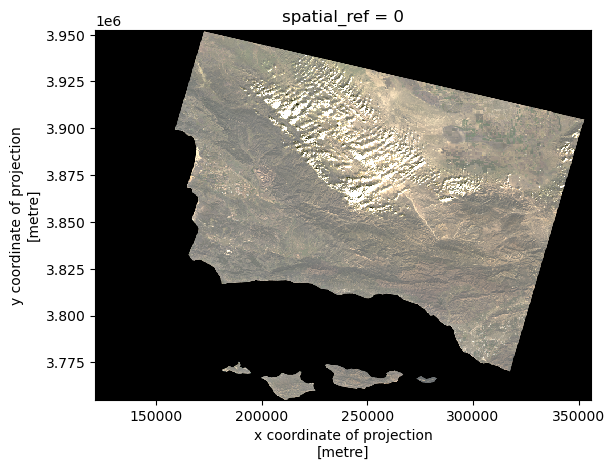

In [11]:
# Set `robust=True` for better color scale while plotting
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

## False color image

False color imagery is a useful tool for monitoring wildfire impacts. By assigning infrared bands to visible colors, these images highlight vegetation health, burn severity, and the extent of fire scars. This approach helps researchers and land managers assess recovery efforts, identify high-risk areas, and plan restoration strategies.

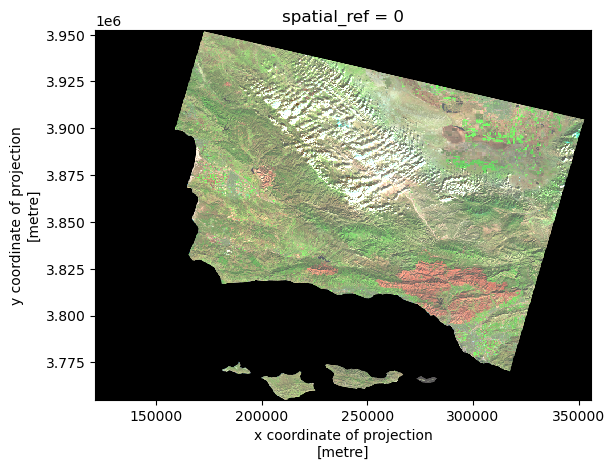

In [12]:
# Create false color visualization using SWIR, NIR and red bands
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

## Maps 

To add the Thomas Fire perimeter we created earlier, import the file and make sure the CRS for `landsat` matches.

In [13]:
# Import the Thomas Fire perimeter
thomasfire = gpd.read_file(os.path.join('data','thomasfire.geojson'))

# Reproject Landsat data to match fire perimeter CRS (coordinate reference system)
thomasfire.crs
landsat = landsat.rio.reproject("EPSG:3310")
assert landsat.rio.crs == thomasfire.crs

Let's create a clipped version to use for plotting as well. 

In [14]:
# Create a false color image and clip it for plotting
falsecolor_thomasfire = landsat[['swir22', 'nir08', 'red']].to_array()

falsecolor_clip = falsecolor_thomasfire.rio.clip_box(*thomasfire.total_bounds)

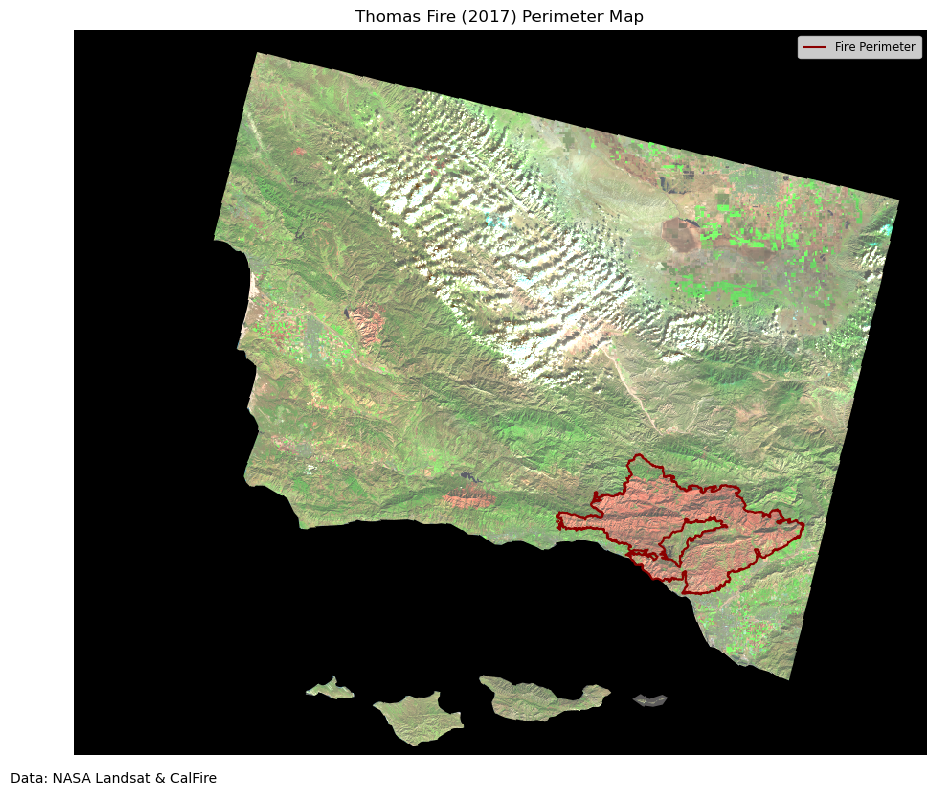

In [15]:
# Create a map showing the false color image together with the Thomas Fire perimeter.
fig, ax = plt.subplots(figsize=(10,8))

ax.axis('off')

falsecolor_thomasfire.plot.imshow(ax=ax, 
                                 robust=True)
thomasfire.geometry.boundary.plot(ax=ax,
                                color='darkred',
                                linewidth=1.5,
                                label="Fire Perimeter")

ax.legend(fontsize='small')
plt.tight_layout()
plt.subplots_adjust(bottom=0.05)

ax.set_title('Thomas Fire (2017) Perimeter Map')

plt.figtext(0.01, 0.015, "Data: NASA Landsat & CalFire", ha="left", fontsize=10)

plt.show()

Let's crop the map to see the fire scar more clearly.

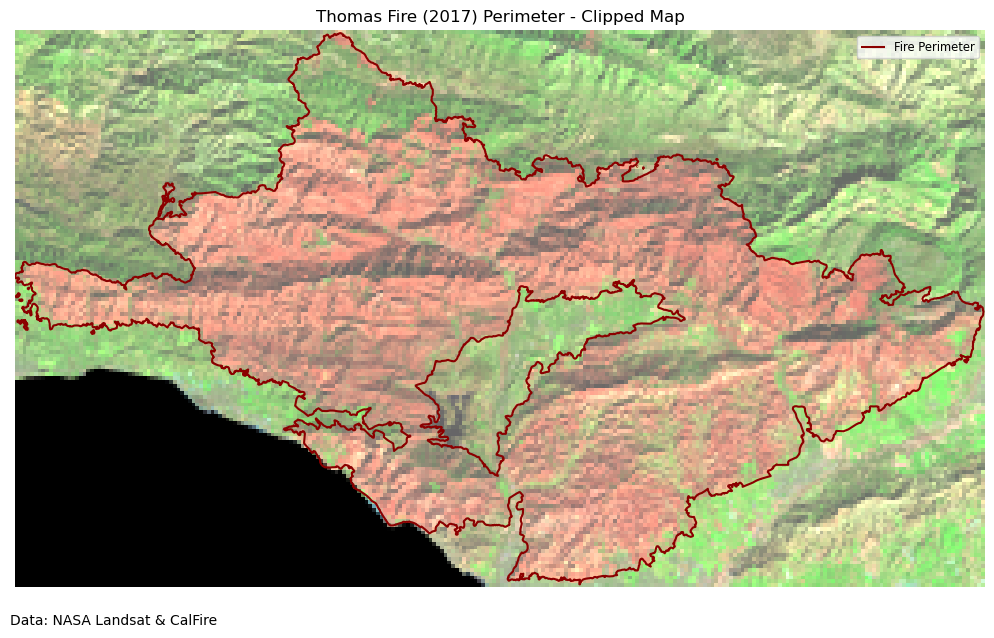

In [16]:
# Create a clipped map showing the false color image and the Thomas Fire perimeter
fig, ax = plt.subplots(figsize=(10,8))

ax.axis('off')

falsecolor_clip.plot.imshow(ax=ax,
                           robust=True)
thomasfire.geometry.boundary.plot(ax=ax,
                                color='darkred',
                                linewidth=1.5,
                                label="Fire Perimeter")

ax.legend(fontsize='small')
plt.tight_layout()
plt.subplots_adjust(bottom=0.05)

ax.set_title('Thomas Fire (2017) Perimeter - Clipped Map')

plt.figtext(0.01, 0.12, "Data: NASA Landsat & CalFire", ha="left", fontsize=10)

plt.show()

The above maps use false color satellite imagery to display the burn scar from the 2017 Thomas Fire and its perimeter. Shortwave infrared (SWIR) is plotted in red, near infrared (NIR) in green, and the red band in blue. Newly burned soil reflects SWIR light strongly, and plants containing water reflect NIR strongly, which makes this false color image helpful for visualizing fire effects.

# Section 2: Land cover statistics

**Dataset Descriptions:**

This section will use two datasets.

The first one is [GAP/LANDFIRE National Terrestrial Ecosystems data for 2011 @davidson_gaplandfire_2016](https://www.sciencebase.gov/catalog/item/573cc51be4b0dae0d5e4b0c5), from the [US Geological Survey (USGS)](https://www.usgs.gov). This is a categorical raster with a 30 m x 30 m pixel resolution representing highly thematically detailed land cover map of the U.S. 

The class names and corresponding codes have been saved to a separate CSV to simplify access. Further information on how to access the classes directly from the data are available in the [MPC catalog](https://planetarycomputer.microsoft.com/dataset/gap#Example-Notebook).

### Clip raster to geometry

We use this ready-to-use raster and the terrestrial ecosystem labels at this directory within workbench-1:

`/courses/EDS220/data/USGS_National_Terrestrial_Ecosystems_Over_Thomas_Fire_Perimeter/`

In [17]:
# Import data
root = os.path.join('/',
                   'courses',
                   'EDS220',
                   'data',
                   'USGS_National_Terrestrial_Ecosystems_Over_Thomas_Fire_Perimeter')

fp1 = os.path.join(root, 'USGS_National_Terrestrial_Ecosystems_Over_Thomas_Fire_Perimeter.tif')

labels = pd.read_csv(os.path.join(root,'GAP_National_Terrestrial_Ecosystems.csv'))

lulc = rioxr.open_rasterio(fp1)
lulc

<xarray.DataArray (band: 1, y: 1434, x: 2228)> Size: 6MB
[3194952 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 18kB -2.136e+06 -2.136e+06 ... -2.07e+06 -2.07e+06
  * y            (y) float64 11kB 1.548e+06 1.548e+06 ... 1.505e+06 1.505e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    _FillValue:              0
    scale_factor:            1.0
    add_offset:              0.0

In [18]:
# Remove length 1 dimension (band)
lulc = lulc.squeeze()#.drop_vars('band')
print("Sizes of dimensions:", dict(lulc.sizes))

Sizes of dimensions: {'y': 1434, 'x': 2228}


Here, we want to clip the raster exactly to the fire perimeter. Clipping can be a costly operation for such a big raster relative to a detailed geometry. So we will perform the clipping in two steps:

1. Clip the raster using the fire perimeter bounding box using rio.clip_box() and then
2. Clip the simplified raster to the fire perimeter using rio.clip().

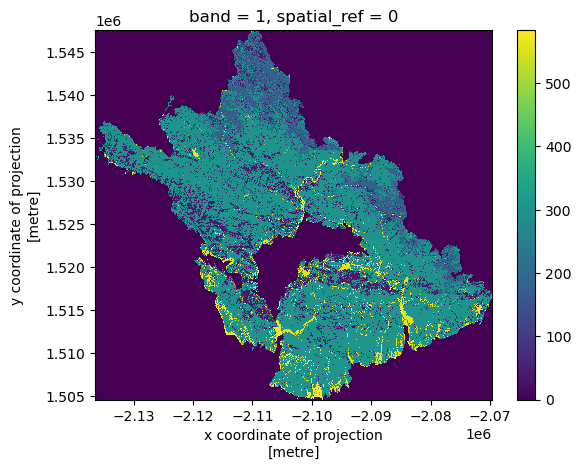

In [19]:
# Match CRSs and verify update
thomasfire_match = thomasfire.to_crs(lulc.rio.crs)
assert thomasfire_match.crs == lulc.rio.crs

lulc_clip = (lulc.rio.clip_box(*thomasfire_match.total_bounds)
                 .rio.clip(thomasfire_match.geometry)
                 )

# Examine results
lulc_clip.plot()                                  

## Compute land cover statistics

Next, we will compute land cover statistics within the Thomas Fire perimeter.

1. Use the `numpy` function `np.unique()` to get the number of pixels per class in `lulc_clip`

In [20]:
np.unique(lulc_clip, return_counts = True)[1]

array([1928032,    6856,     361,  133693,    3635,   23147,    2907,
          4973,    3725,   60196,    5102,   75909,     376,   11098,
            29,      98,   64065,   69699,  183949,  454453,   88490,
           799,     749,     683,      28,      90,     865,     262,
          1329,      54,      44,      27,     298,      24,      15,
            43,       7,   18992,    2180,     485,      13,      20,
            10,    1855,   40627,    3773,     829,      58])

2. Create a data frame `pix_counts` with two columns: the code numbers for the pixels in `lulc_clip` and the number of pixels corresponding to each code

In [21]:
pix_counts = {
    'Class': np.unique(lulc_clip),
    'counts': np.unique(lulc_clip, return_counts = True)[1]
}

pix_counts = pd.DataFrame(pix_counts)
pix_counts.head()

,Class,counts
0,0,1928032
1,39,6856
2,40,361
3,41,133693
4,42,3635


3. Use the `labels` data frame to add the class names to the codes in the `pix_counts` data frame. Store the resulting data frame as `classes`.

In [22]:
# Rename the 'code' column in labels to match 'Class' in pix_counts
labels = labels.rename(columns={'code': 'Class'})

# Merge the dataframes
classes = pd.merge(pix_counts, labels, on='Class', how='left')
classes.head()

,Class,counts,class_label
0,0,1928032,0
1,39,6856,California Central Valley Mixed Oak Savanna
2,40,361,California Coastal Closed-Cone Conifer Forest ...
3,41,133693,California Coastal Live Oak Woodland and Savanna
4,42,3635,California Lower Montane Blue Oak-Foothill Pin...


5. What area within the fire perimeter (in km^2) was estimated to be developed? The raster has a resolution of 30m.

In [23]:
# Area of the Thomas Fire in square kilometers
thomasfire_area_km = thomasfire.area / 1e+6
thomasfire_area_km

0    1140.367254
dtype: float64

In [26]:
# Find the area of classes labeled as "Developed". These are located at 581-584.
area_km_developed = classes[classes.Class.isin([581, 582, 583, 584])].counts.sum() * 30*30 / 1e+6
area_km_developed

40.7583

What percent of the total area burned was developed?

In [27]:
print((area_km_developed/thomasfire_area_km*100)[0], "% ")

3.5741380568744074 % 


6. Store the total number of pixels within the fire perimeter as a variable `total_pixels`

In [32]:
total_pixels = classes.counts.sum()
total_pixels

3194952

7. Add the percentage of area covered by each class as a new column percentage to the `classes` data frame. Sort the data frame by percentage coverage in descending order.

In [33]:
classes['percent'] = classes["counts"] / classes['counts'].sum()*100
classes = classes.sort_values(by = 'percent', ascending=False)

8. Create a horizontal bar plot showing the classes with more than 1% land cover in decreasing order.

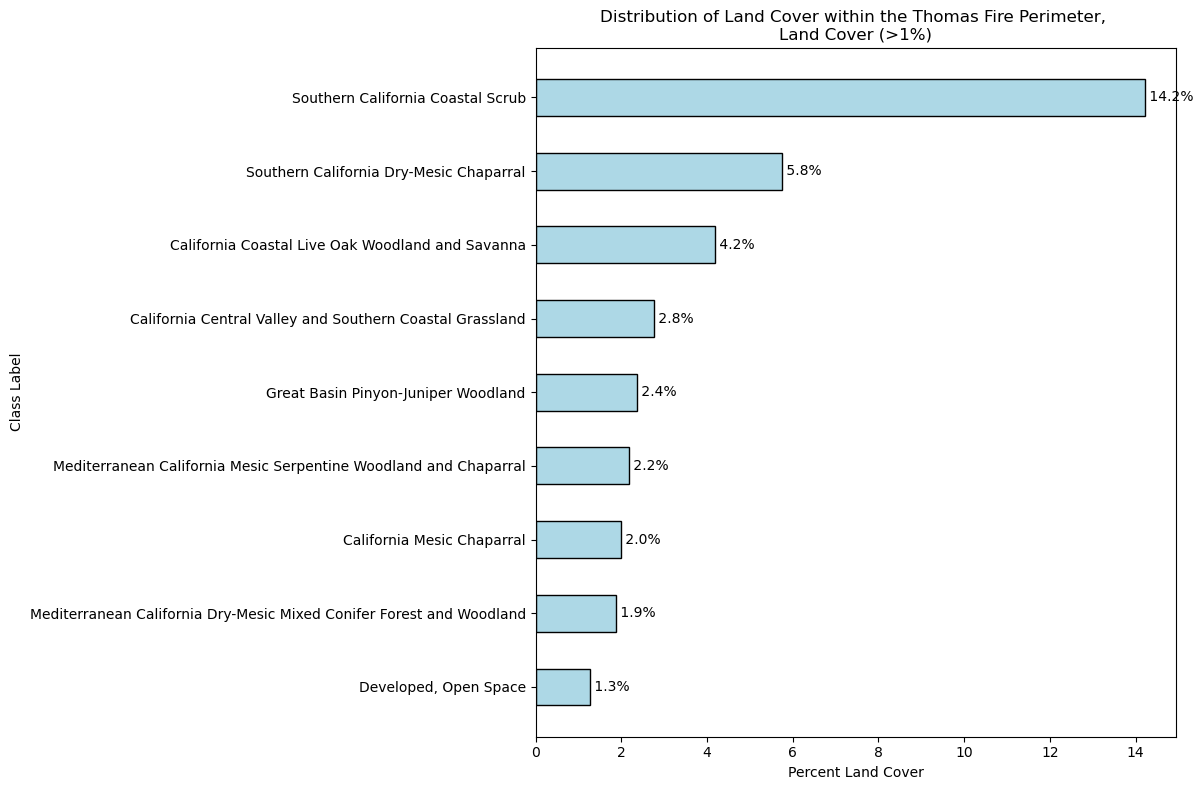

In [34]:
# Filter for classes with >1% coverage and sort by percent in descending order
filtered_classes = classes[
    (classes['percent'] > 1) & 
    (classes['Class'] != 0)
].sort_values('percent', ascending=True)

# Create the horizontal bar plot
plt.figure(figsize=(12, 8))
plt.barh(filtered_classes['class_label'], filtered_classes['percent'],
        height = 0.5,
        color = 'lightblue',
        edgecolor = 'black')

plt.xlabel('Percent Land Cover')
plt.ylabel('Class Label')
plt.title('Distribution of Land Cover within the Thomas Fire Perimeter, \nLand Cover (>1%)')

for i, v in enumerate(filtered_classes['percent']):
    plt.text(v, i, f' {v:.1f}%', va='center')

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()